# Delivery 04 : Dynamic Dashboard for SIR Modelling

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime
import pandas as pd 

from scipy import optimize
from scipy import integrate

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import os

sns.set(style="darkgrid")

mpl.rcParams['figure.figsize'] = (16, 9)
pd.set_option('display.max_rows', 500)

In [2]:
url='https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
pd_raw=pd.read_csv(url)
time_idx=pd_raw.columns[4:]
df_plot = pd.DataFrame({'date':time_idx})

country_list=['India',
              'US',
              'Canada',
              'Germany',
              'Australia',
              'Singapore'
             ] 

for each in country_list:
    df_plot[each]=np.array(pd_raw[pd_raw['Country/Region']==each].iloc[:,4::].sum(axis=0))

time_idx=[datetime.strptime( each,"%m/%d/%y") for each in df_plot.date] # convert to datetime
time_str=[each.strftime('%Y-%m-%d') for each in time_idx] # convert back to date ISO norm (str)
df_plot['date']=time_idx
filepath = os.path.join(os.getcwd(),'COVID_small_flat_table.csv')
df_plot.to_csv(filepath,sep=';',index=False)

In [3]:
filepath = os.path.join(os.getcwd(),'COVID_small_flat_table.csv')

df_analyse=pd.read_csv(filepath,sep=';')  
df_analyse.sort_values('date',ascending=True).tail()

,date,India,US,Canada,Germany,Australia,Singapore
913,2022-07-23,43888755,90398709,4061530,30331133,9103321,1652981
914,2022-07-24,43905621,90410386,4062808,30331133,9136110,1659156
915,2022-07-25,43920451,90567290,4064084,30476605,9185736,1664707
916,2022-07-26,43938764,90733888,4071469,30598385,9235196,1677126
917,2022-07-27,43959321,90973418,4074977,30702511,9282271,1685889


**SIR Modelling parameter fitting**

* Dynamic dashoard for fit curve
* SIR curve of various countries


In [4]:
# Extracting data of desired countries
df_an = df_analyse[country_list]

In [5]:
N0=1000000 #max susceptible population 
beta=0.4  # recovery coefficient
gamma=0.1  # Transmission coefficient

# Generating a dataframe of infected, recovered and susceptible population of the selected countries
df = pd.DataFrame()

for country in country_list:
    I0 = df_an._get_value(35,country)
    S0=N0-I0
    R0=0
    
    dict1 = {'country': country, 'susceptible':S0, 'infected':I0,'recoverd':R0}
                                           
    
    
    df = df.append(dict1, ignore_index=True)
print(df)

     country  infected  recoverd  susceptible
0      India       3.0       0.0     999997.0
1         US      16.0       0.0     999984.0
2     Canada      20.0       0.0     999980.0
3    Germany      21.0       0.0     999979.0
4  Australia      15.0       0.0     999985.0
5  Singapore      93.0       0.0     999907.0


**Simulative approach to calculate SIR curve**

In [6]:
N0=1000000 #max susceptible population 
beta=0.4  # recovery coefficient
gamma=0.1  # Transmission coefficient
propagation_rates=pd.DataFrame(index = [country],columns={'susceptible':S0,
                                           'infected':I0,
                                           'recoverd':R0})

def SIR_model(SIR,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return([dS_dt,dI_dt,dR_dt])

for country in country_list:
    I0 = df_an._get_value(35,country)
    S0=N0-I0
    R0=0
    
    SIR=np.array([S0,I0,R0])
    
    for each_t in np.arange(100):
        new_delta_vec=SIR_model(SIR,beta,gamma)
   
        SIR=SIR+new_delta_vec
    
        propagation_rates=propagation_rates.append({'country': country,'susceptible':SIR[0],
                                                'infected':SIR[1],
                                                'recovered':SIR[2]}, ignore_index=True)


        
print(propagation_rates.head())

     susceptible  infected  recoverd country  recovered
0            NaN       NaN       NaN     NaN        NaN
1  999995.800004  3.899996       NaN   India   0.300000
2  999994.240012  5.069989       NaN   India   0.690000
3  999992.212028  6.590974       NaN   India   1.196999
4  999989.575659  8.568245       NaN   India   1.856096


**SIR_curve-CANADA**

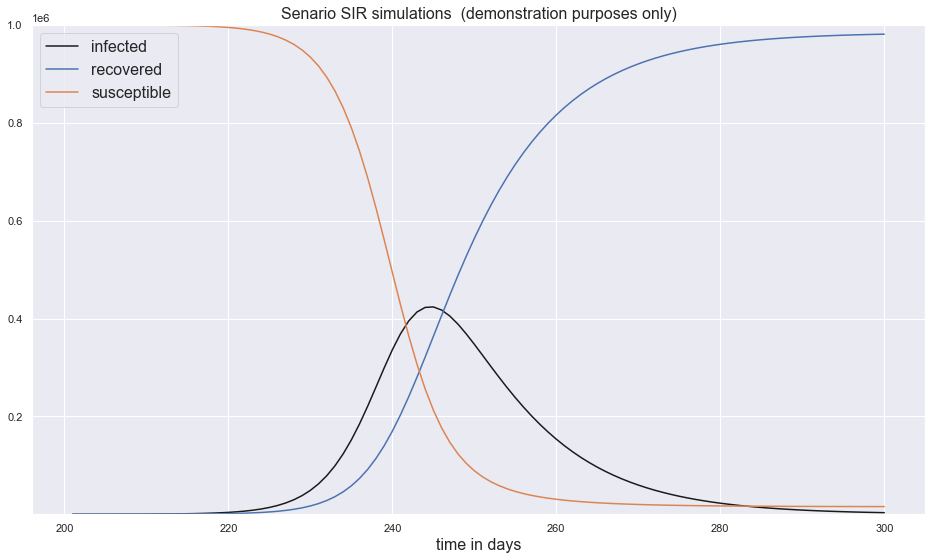

In [7]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index[201:301],propagation_rates.infected[201:301],label='infected',color='k')
ax1.plot(propagation_rates.index[201:301],propagation_rates.recovered[201:301],label='recovered')
ax1.plot(propagation_rates.index[201:301],propagation_rates.susceptible[201:301],label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Senario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

**SIR_curve-DEUTSCHLAND**

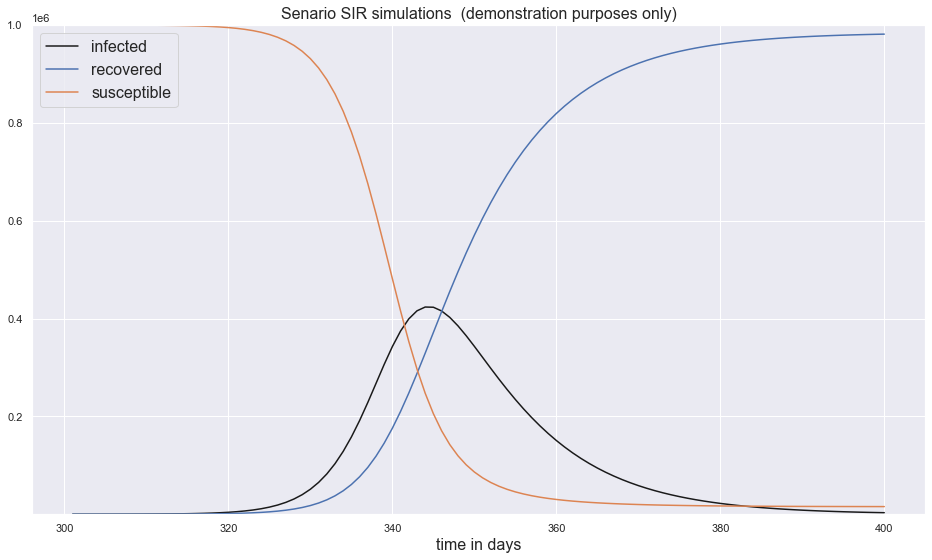

In [8]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(propagation_rates.index[301:401],propagation_rates.infected[301:401],label='infected',color='k')
ax1.plot(propagation_rates.index[301:401],propagation_rates.recovered[301:401],label='recovered')
ax1.plot(propagation_rates.index[301:401],propagation_rates.susceptible[301:401],label='susceptible')

ax1.set_ylim(10, 1000000)
ax1.set_yscale('linear')
ax1.set_title('Senario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

**Fitting parameters for SIR Model**

In [9]:
def SIR_model_t(SIR,t,beta,gamma):
    ''' Simple SIR model
        S: susceptible population
        t: time step, mandatory for integral.odeint
        I: infected people
        R: recovered people
        beta: 
        
        overall condition is that the sum of changes (differnces) sum up to 0
        dS+dI+dR=0
        S+I+R= N (constant size of population)
    
    '''
    
    S,I,R=SIR
    dS_dt=-beta*S*I/N0          
    dI_dt=beta*S*I/N0-gamma*I
    dR_dt=gamma*I
    return dS_dt,dI_dt,dR_dt

In [10]:
def fit_odeint(x, beta, gamma):
    '''
    helper function for the integration
    '''
    return integrate.odeint(SIR_model_t, (S0, I0, R0), t, args=(beta, gamma))[:,1] 

In [11]:

df1 = pd.DataFrame()
for country in country_list:
    ydata = np.array(df_analyse[country][35:])
    t = np.arange(len(ydata))
    # ensure re-initialization 
    I0=ydata[0]
    S0=N0-I0
    R0=0
    beta
    
    # example curve of our differential equationa
    popt=[0.4,0.1]
    fit_odeint(t, *popt)
    
    
    popt, pcov = optimize.curve_fit(fit_odeint, t, ydata)
    perr = np.sqrt(np.diag(pcov))
    
    print('standard deviation errors : ',str(perr), ' start infect:',ydata[0])
    print("Optimal parameters: beta =", popt[0], " and gamma = ", popt[1])
    
    
    # get the final fitted curve
    fitted=fit_odeint(t, *popt)
    df1 = df1.append({'country': country,'t': t, 'ydata':ydata,'fitted':fitted},ignore_index=True)


/opt/anaconda3/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
<ipython-input-9-20242b6e9de4>:16: RuntimeWarning: overflow encountered in double_scalars
  dS_dt=-beta*S*I/N0
<ipython-input-9-20242b6e9de4>:17: RuntimeWarning: overflow encountered in double_scalars
  dI_dt=beta*S*I/N0-gamma*I
<ipython-input-9-20242b6e9de4>:18: RuntimeWarning: overflow encountered in double_scalars
  dR_dt=gamma*I


standard deviation errors :  [517.14282856 515.8201405 ]  start infect: 3
Optimal parameters: beta = 1.0492753743853194  and gamma =  0.9507031216141639
standard deviation errors :  [325.45832273 322.76835512]  start infect: 16
Optimal parameters: beta = 1.099390365051846  and gamma =  0.8998429798437906
standard deviation errors :  [2.35839011e-04 1.66514326e-05]  start infect: 20
Optimal parameters: beta = 0.029789376349439192  and gamma =  -0.002678648502722473
standard deviation errors :  [74.78713281 74.21456975]  start infect: 21
Optimal parameters: beta = 1.0989413485519077  and gamma =  0.8990898117534166
standard deviation errors :  [48.74584111 48.18908638]  start infect: 15
Optimal parameters: beta = 1.052612529406686  and gamma =  0.9446419353027914
standard deviation errors :  [8.51030728e-05 6.05030445e-05]  start infect: 93
Optimal parameters: beta = 0.00948715010821365  and gamma =  -0.0033123028029072524


In [12]:
# Final dataframe
d_fin = pd.DataFrame({'timeline' : df1.t[0],'India_fit': df1.fitted[0],  'India' : df1.ydata[0],
                      'US_fit': df1.fitted[1], 'US': df1.ydata[1],
                  'Canada_fit': df1.fitted[2], 'Canada': df1.ydata[2],
                  'Germany_fit': df1.fitted[3], 'Germany' : df1.ydata[3],
                     'Australia_fit': df1.fitted[4] , 'Australia': df1.ydata[4] ,
                      'Singapore_fit': df1.fitted[5] , 'Singapore': df1.ydata[5] })



**Curve for Australia**

* Original and fitted population

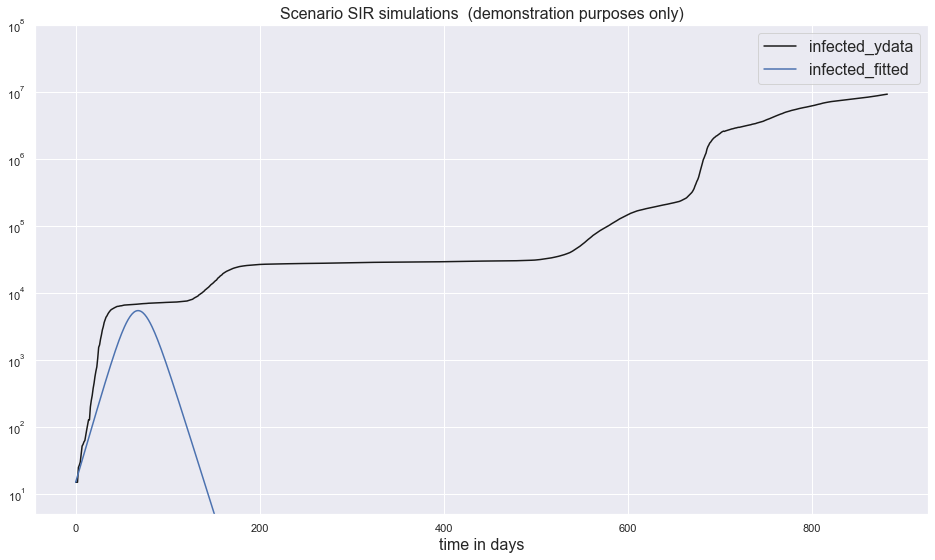

In [13]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(df1.t[4],df1.ydata[4],label='infected_ydata',color='k')
ax1.plot(df1.t[4],df1.fitted[4],label='infected_fitted')

ax1.set_ylim(5, 100000000)
ax1.set_yscale('log')
ax1.set_title('Scenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

**Curve for Germany**

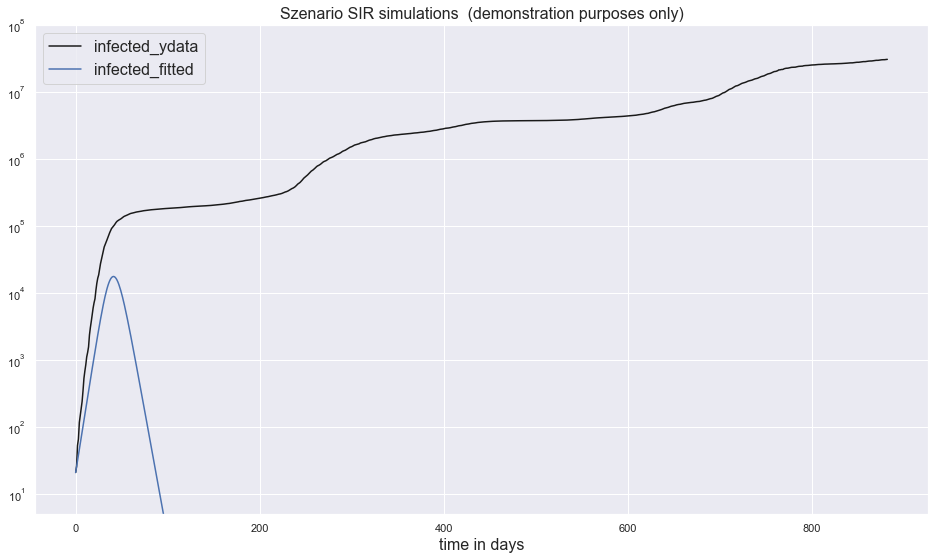

In [14]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(df1.t[3],df1.ydata[3],label='infected_ydata',color='k')
ax1.plot(df1.t[3],df1.fitted[3],label='infected_fitted')

ax1.set_ylim(5, 100000000)
ax1.set_yscale('log')
ax1.set_title('Szenario SIR simulations  (demonstration purposes only)',size=16)
ax1.set_xlabel('time in days',size=16)
ax1.legend(loc='best',
           prop={'size': 16});

# Dynamic Dashboard

* Use of Dash Plotly

In [15]:

import pandas as pd
import numpy as np

import dash
dash.__version__
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output,State

import plotly.graph_objects as go

import os



fig = go.Figure()

app = dash.Dash()
app.layout = html.Div([
    dcc.Markdown('''
    #  Dynamic Dashboard
    (Using Dash Plotly)

    Goal of the exercise is to select and visualise the SIR simulation of different countries.

    '''),
    
   
    html.Br(),
    html.Br(),

    dcc.Dropdown(
        id='country_drop_down',
        options=[ {'label': 'India','value':'India'},
                  {'label': 'US','value':'US'},
                  {'label': 'Canada','value':'Canada'},
                 {'label': 'Germany','value':'Germany'},
                 {'label': 'Australia','value':'Australia'},
                 {'label': 'Singapore','value':'Singapore'},
                ],
        value=['Singapore'],# which are pre-selected
        placeholder = 'Multi-Select Country for Visualization',
        multi=True
    ),


    dcc.Graph(figure=fig, id='main_window_slope')
])

<ipython-input-15-b47824af9865>:6: UserWarning: 
The dash_core_components package is deprecated. Please replace
`import dash_core_components as dcc` with `from dash import dcc`
  import dash_core_components as dcc
<ipython-input-15-b47824af9865>:7: UserWarning: 
The dash_html_components package is deprecated. Please replace
`import dash_html_components as html` with `from dash import html`
  import dash_html_components as html


In [16]:
@app.callback(Output('main_window_slope', 'figure'),[Input('country_drop_down', 'value')])

def update_figure(country_list):
    
    traces = []
    for each in country_list:
        traces.append(dict(x=d_fin.timeline,y=d_fin[str(each + '_fit')],mode='markers+lines',opacity=0.9,name=str(each+"_fit")))
            
        traces.append(dict(x=d_fin.timeline,y=d_fin[each],mode='markers+lines',opacity=0.9,name= str(each+"_ydata")))

    return {
            'data': traces,
            'layout': dict(width=1280,height=720, title = 'SIR Curve for Infected people alongiwith with fit curve',
                            xaxis={'title':'Timeline in days','tickangle':-45,'nticks':20,'tickfont':dict(size=14,color='ylorbr')},
                            yaxis= {'title':'New Population Infected','type':"log",'range':'[1.1,5.5]'})}

In [ ]:
if __name__ == '__main__':

    app.run_server(port = 4086,debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:4086/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on
